In [1]:


import os
import sys
import ast
import torch
import cv2 
import importlib
import pandas as pd
import albumentations as a

from tqdm.notebook import tqdm
tqdm.pandas()

from PIL import Image
from IPython.display import display

from sceneRadianceCLAHE import RecoverCLAHE
from sceneRadianceHE import RecoverHE

import warnings
warnings.filterwarnings("ignore")
sys.path.append('../input/underwater-image-enhancement/Underwater Image Enhancement/CLAHE')


In [3]:
%cp -r /kaggle/input/yolox-cots-models /kaggle/working/
%cp -r /kaggle/input/pytorch-underwater-image-enhancement/PyTorch-Underwater-Image-Enhancement /kaggle/working/

%cd /kaggle/working/yolox-cots-models/yolox-dep

/kaggle/working/yolox-cots-models/yolox-dep


In [ ]:
# Install YOLOX required modules

%pip install -q pip-21.3.1-py3-none-any.whl -f ./ --no-index
%pip install -q loguru-0.5.3-py3-none-any.whl -f ./ --no-index
%pip install -q ninja-1.10.2.3-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl -f ./ --no-index
%pip install -q onnx-1.8.1-cp37-cp37m-manylinux2010_x86_64.whl -f ./ --no-index
%pip install -q onnxruntime-1.8.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl -f ./ --no-index
%pip install -q onnxoptimizer-0.2.6-cp37-cp37m-manylinux2014_x86_64.whl -f ./ --no-index
%pip install -q thop-0.0.31.post2005241907-py3-none-any.whl -f ./ --no-index
%pip install -q tabulate-0.8.9-py3-none-any.whl -f ./ --no-index

In [ ]:
# Install YOLOX
%cd /kaggle/working/yolox-cots-models/YOLOX
%pip install -q -r requirements.txt
%pip install -v -e . 

In [ ]:
# Install CocoAPI tool
%cd /kaggle/working/yolox-cots-models/yolox-dep/cocoapi/PythonAPI

!make
!make install
!python setup.py install

In [7]:
import pycocotools

In [ ]:
#https://www.kaggle.com/parapapapam/yolox-inference-tracking-on-cots-lb-0-539/notebook
# norfair dependencies
%cd /kaggle/input/norfair031py3/
%pip install -q commonmark-0.9.1-py2.py3-none-any.whl -f ./ --no-index
%pip install -q rich-9.13.0-py3-none-any.whl

!mkdir /kaggle/working/tmp
!cp -r /kaggle/input/norfair031py3/filterpy-1.4.5/filterpy-1.4.5/ /kaggle/working/tmp/
%cd /kaggle/working/tmp/filterpy-1.4.5/
%pip install .
!rm -rf /kaggle/working/tmp

# norfair
%cd /kaggle/input/norfair031py3/
%pip install -q norfair-0.3.1-py3-none-any.whl -f ./ --no-index
%cd /kaggle/working

In [ ]:
TRAIN_ROOT_DIR = '../input/cotts-processed-csv'

def get_path(row):
    row['image_path'] = f'{TRAIN_ROOT_DIR}/train_images/video_{row.video_id}/{row.video_frame}.jpg'
    return row

# Train Data
train_df = pd.read_csv(f'{TRAIN_ROOT_DIR}/train-5-folds.csv')
train_df = train_df.progress_apply(get_path, axis=1)
train_df['annotations'] = train_df['annotations'].progress_apply(lambda x: ast.literal_eval(x))
display(train_df.head(2))

FDA_reference = train_df[train_df['annotations']!='[]']
FDA_transform = a.FDA(FDA_reference['image_path'].values)

In [10]:
%cp -r ../input/cotts-yolox/best_ckpt.pth /kaggle/working/yolox-cots-models

In [11]:
%cd /kaggle/working/yolox-cots-models/YOLOX

CHECKPOINT_FILE = '/kaggle/working/yolox-cots-models/best_ckpt.pth'
YOLOX_MODEL_ARCH = 'MEDIUM'

/kaggle/working/yolox-cots-models/YOLOX


In [12]:
if YOLOX_MODEL_ARCH == 'MEDIUM':
    config_file_template = '''

#!/usr/bin/env python3
# -*- coding:utf-8 -*-
# Copyright (c) Megvii, Inc. and its affiliates.

import os

from yolox.exp import Exp as MyExp


class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = 0.67
        self.width = 0.75
        self.exp_name = os.path.split(os.path.realpath(__file__))[1].split(".")[0]
        self.num_classes = 1

'''

In [13]:
if YOLOX_MODEL_ARCH == 'LARGE':
    config_file_template = '''

#!/usr/bin/env python3
# -*- coding:utf-8 -*-
# Copyright (c) Megvii, Inc. and its affiliates.

import os

from yolox.exp import Exp as MyExp


class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = 1
        self.width = 1
        self.exp_name = os.path.split(os.path.realpath(__file__))[1].split(".")[0]
        self.num_classes = 1

'''

In [15]:
with open('cots_config.py', 'w') as f:
    f.write(config_file_template)

In [16]:
from yolox.utils import postprocess
from yolox.data.data_augment import ValTransform

COCO_CLASSES = (
  "starfish",
)

# get YOLOX experiment
current_exp = importlib.import_module('cots_config')
exp = current_exp.Exp()

# set inference parameters
test_size = (1440, 1920)
num_classes = 1
confthre = 0.15
nmsthre = 0.4
FDA_AUG = True

# get YOLOX model
model = exp.get_model()
model.cuda()
model.eval()

# get custom trained checkpoint
ckpt_file = CHECKPOINT_FILE
ckpt = torch.load(ckpt_file, map_location="cpu")
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

In [17]:
def yolox_inference(img, model, test_size): 
    bboxes = []
    bbclasses = []
    scores = []
    
    preproc = ValTransform(legacy = False)

    tensor_img, _ = preproc(img, None, test_size)
    tensor_img = torch.from_numpy(tensor_img).unsqueeze(0)
    tensor_img = tensor_img.float()
    tensor_img = tensor_img.cuda()

    with torch.no_grad():
        outputs = model(tensor_img)
        outputs = postprocess(
                    outputs, num_classes, confthre,
                    nmsthre, class_agnostic=True
                )

    if outputs[0] is None:
        return [], [], []
    
    outputs = outputs[0].cpu()
    bboxes = outputs[:, 0:4]

    bboxes /= min(test_size[0] / img.shape[0], test_size[1] / img.shape[1])
    bbclasses = outputs[:, 6]
    scores = outputs[:, 4] * outputs[:, 5]
    
    return bboxes, bbclasses, scores

In [19]:
def draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, classes_dict):
    for i in range(len(bboxes)):
            box = bboxes[i]
            cls_id = int(bbclasses[i])
            score = scores[i]
            if score < confthre:
                continue
            x0 = int(box[0])
            y0 = int(box[1])
            x1 = int(box[2])
            y1 = int(box[3])

            cv2.rectangle(img, (x0, y0), (x1, y1), (0, 255, 0), 2)
            cv2.putText(img, '{}:{:.1f}%'.format(classes_dict[cls_id], score * 100), (x0, y0 - 3), cv2.FONT_HERSHEY_PLAIN, 0.8, (0,255,0), thickness = 1)
    return img

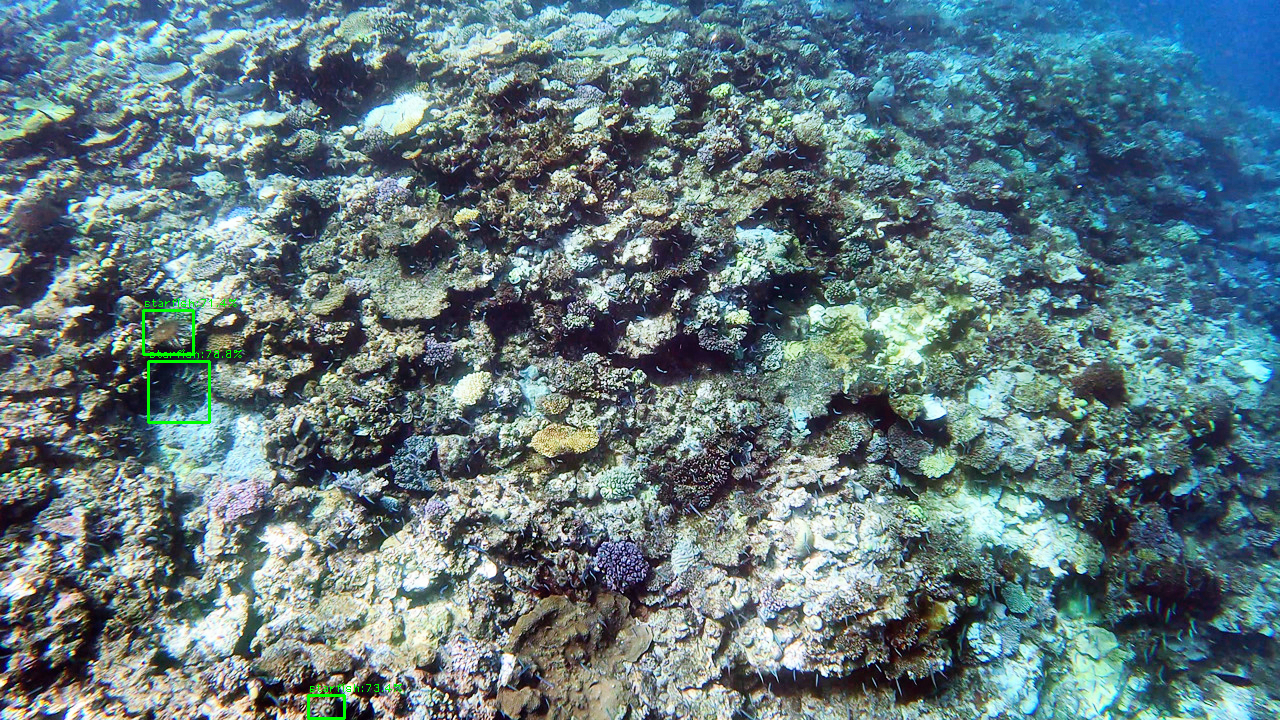

In [20]:
TEST_IMAGE_PATH = "/kaggle/input/tensorflow-great-barrier-reef/train_images/video_0/9674.jpg"
img = cv2.imread(TEST_IMAGE_PATH)
img = RecoverCLAHE(img)
    
# Get predictions
bboxes, bbclasses, scores = yolox_inference(img, model, test_size)

# Draw predictions
out_image = draw_yolox_predictions(img, bboxes, scores, bbclasses, confthre, COCO_CLASSES)

out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)
display(Image.fromarray(out_image))

In [21]:
%cd /kaggle/working/

/kaggle/working


In [22]:
import greatbarrierreef

env = greatbarrierreef.make_env()   # initialize the environment
iter_test = env.iter_test()  

In [23]:
#https://www.kaggle.com/parapapapam/yolox-inference-tracking-on-cots-lb-0-539/notebook

##############################################################
#                      Tracking helpers                      #
##############################################################

import numpy as np
from norfair import Detection, Tracker

# Helper to convert bbox in format [x_min, y_min, x_max, y_max, score] to norfair.Detection class
def to_norfair(detects, frame_id):
    result = []
    for x_min, y_min, x_max, y_max, score in detects:
        xc, yc = (x_min + x_max) / 2, (y_min + y_max) / 2
        w, h = x_max - x_min, y_max - y_min
        result.append(Detection(points=np.array([xc, yc]), scores=np.array([score]), data=np.array([w, h, frame_id])))
        
    return result

# Euclidean distance function to match detections on this frame with tracked_objects from previous frames
def euclidean_distance(detection, tracked_object):
    return np.linalg.norm(detection.points - tracked_object.estimate)

In [24]:
import matplotlib.pyplot as plt

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Prediction: 
Prediction: 
Prediction: 


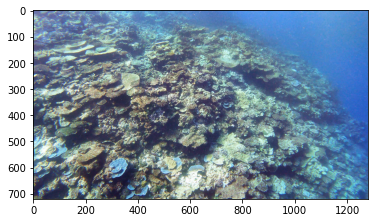

In [25]:
submission_dict = {
    'id': [],
    'prediction_string': [],
}


#######################################################
#                      Tracking                       #
#######################################################

# Tracker will update tracks based on detections from current frame
# Matching based on euclidean distance between bbox centers of detections 
# from current frame and tracked_objects based on previous frames
# You can check it's parameters in norfair docs
# https://github.com/tryolabs/norfair/blob/master/docs/README.md
tracker = Tracker(
    distance_function=euclidean_distance, 
    distance_threshold=30,
    hit_inertia_min=3,
    hit_inertia_max=6,
    initialization_delay=1,
)

# Save frame_id into detection to know which tracks have no detections on current frame
frame_id = 0
#######################################################


for (image_np, sample_prediction_df) in iter_test:
    image_np = RecoverCLAHE(image_np)
    bboxes, bbclasses, scores = yolox_inference(image_np[:,:,::-1], model, test_size)
    
    predictions = []
    detects = []
    for i in range(len(bboxes)):
        box = bboxes[i]
        cls_id = int(bbclasses[i])
        score = scores[i]
        if score < confthre:
            continue
        x_min = int(box[0])
        y_min = int(box[1])
        x_max = int(box[2])
        y_max = int(box[3])
        detects.append([x_min, y_min, x_max, y_max, score])
        
        bbox_width = x_max - x_min
        bbox_height = y_max - y_min
        
        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
    
    #######################################################
    #                      Tracking                       #
    #######################################################
    
    # Update tracks using detects from current frame
    tracked_objects = tracker.update(detections=to_norfair(detects, frame_id))
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue
            
        # Add objects that have no detections on current frame to predictions
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))
        score = tobj.last_detection.scores[0]

        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
    #######################################################
    
    prediction_str = ' '.join(predictions)
    sample_prediction_df['annotations'] = prediction_str
    env.predict(sample_prediction_df)
    
    if frame_id < 3:
        plt.imshow(image_np)

    print('Prediction:', prediction_str)
    frame_id += 1

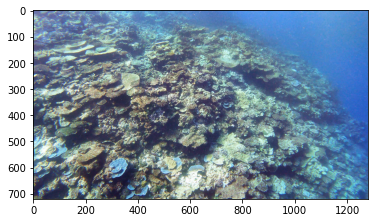

In [26]:
plt.imshow(image_np)

In [ ]:
sub_df = pd.read_csv('submission.csv')
sub_df.head()